# A) load data

After this step, you should end up with an array with all the sentences in your dataset

In [1]:
from datasets import load_dataset

# dataset = load_dataset("trivia_qa", 'rc.nocontext')
dataset = load_dataset("super_glue", "axb")
# dataset = load_dataset("qwedsacf/grade-school-math-instructions")

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration qwedsacf--grade-school-math-instructions-27f3498f0a6417ed


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


Dataset parquet downloaded and prepared to /n/home10/cyeh/.cache/huggingface/datasets/qwedsacf___parquet/qwedsacf--grade-school-math-instructions-27f3498f0a6417ed/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 87.87it/s]


In [6]:
test_data = dataset['train']
print(len(test_data))

8792


## sample from data

In [8]:
# prepare for sampling
import random
num_examples = 120
random.seed(10) # set seed
# indices = random.sample(range(len(test_data)), num_examples)
# indices[:10]

In [39]:
# pick 'num_examples' math instructions
sentences = []
sent_lengths = []
for i in indices:
    point = test_data[i]
    sent = point['INSTRUCTION'].lower().split()
    sent_len = len(sent)
    if sent_len > 100: # skip really long sentences
        continue
    sent_lengths.append(sent_len)
    sentences.append(' '.join(sent)) # add to list
 
sentences[:10]

['there were 100 jelly beans in a bag to be given away on halloween. out of the 40 children taking part in the halloween celebration, 80% were allowed to draw jelly beans from the bag. each child drew two jelly beans out of the bag. how many jelly beans remained in the bag after the children took their share? how to solve this?',
 'alton owns a business. he is currently renting a space that costs $20 per week. if alton earns $8 per day, how much is his total profit every week? solve this problem.',
 '15 gallons of gas were equally divided into 5 different containers. josey needed 1/4 of a container to run her lawnmower. how many pints of gasoline did josey need? can you solve this problem?',
 'mckenna starts her day at 8:00 a.m. she works in her office up to 11:00 a.m. then joins her team of developers at the conference room to talk about projects up to 13:00, from which she works for another two hours and then heads home. how many hours does mckenna stay at work?',
 "i need a clearer 

In [40]:
# look at distribution of sentences
max_len = max(sent_lengths)
min_len = min(sent_lengths)
mean_len = sum(sent_lengths)/len(sent_lengths)

print(max_len)
print(min_len)
print(mean_len)

min_ind = sent_lengths.index(min_len)
print(sentences[min_ind])

98
18
48.3728813559322
there are 6 dogs and 2 ducks in the garden. how many feet are there in the garden?


In [9]:
# save sentences if desired (to load back, use: np.load("qa_sentences.npy"))
import numpy as np
# np.save("math_sentences.npy", sentences)

## archive

In [ ]:
# pick 'num_examples' random entailment pairs
sentences = []
sent_lengths = []
for i in indices:
    point = test_data[i]
    sent1 = point['sentence1']
    sent2 = point['sentence2']
    sent = sent1 + " " + sent2 # create sentence pair
    if sent not in sentences:
        sentences.append(sent.lower()) # add to list
        sent_lengths.append(len(sent.split()))
 
sentences[:10]

In [ ]:
# pick 'num_examples' random Q/A pairs
sentences = []
sent_lengths = []
for i in indices:
    point = test_data[i]
    question = point['question'].lower()
    if question[-1] != '?': # add question mark if needed
        question += '?'
    answer = point['answer']['value'].lower()
    sent = question + " " + answer # create sentence from q/a pair
    sentences.append(sent) # add to list
    sent_lengths.append(len(sent.split()))
    
sentences[:10]

# b) get necessary info

Here we use helper methods from Jesse Vig's bertviz repo: https://github.com/jessevig/bertviz
* the cell below may take a while to run... this is normal

In [3]:
# if needed, load back sentences
# sentences = np.load("math_sentences.npy")
# sentences = np.load("axb_sentences.npy")
# sentences = np.load("qa_sentences.npy")
sentences = np.load("sentences.npy")

In [4]:
sentences = sentences[:200]

In [5]:
# import methods from bertviz
from bertviz import neuron_view
from bertviz.transformers_neuron_view import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer
import string

# BERT
# model_type = 'bert'
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# GPT
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

# may need to change depending on your model
num_heads = 12
num_layers = 12

# master dictionary for all values
attn_dict = {'left_text': [], 
             'right_text': [], 
             'positions': [],
             'normalized_positions': [],
             'sentences': [],
             'tokenized_sentences': [],
             'q_norms': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'k_norms': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'queries': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)], 
             'keys': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'attn': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
             'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

for s in sentences:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    # append to master dictionary
    tokens = s_dict['left_text']
    attn_dict['left_text'].extend(tokens)
    attn_dict['right_text'].extend(s_dict['right_text'])
    
    for index in range(len(tokens)): # save position of token and tokenized sentences too
        attn_dict['positions'].append(index)
        attn_dict['normalized_positions'].append(index / (len(tokens) - 1))
        attn_dict['sentences'].append(s)
        attn_dict['tokenized_sentences'].append(' '.join(tokens))
        
    for i in range(num_layers): # updating cumulative q/k vectors + attn + dp
        for j in range(num_heads):
            q = attn_dict['queries'][i][j]
            k = attn_dict['keys'][i][j]
            a = attn_dict['attn'][i][j]
            d = attn_dict['dot_prod'][i][j]
            q_norm = attn_dict['q_norms'][i][j]
            k_norm = attn_dict['k_norms'][i][j]
            
            if len(q) == 1: # on first round, need to empty list (random string was placeholder)
                q.clear()
            query = s_dict['queries'][i][j]
            q.extend(query)
            np_query = np.array(query)

            if len(k) == 1:
                k.clear()
            key = s_dict['keys'][i][j]
            k.extend(key)
            np_key = np.array(key)
            
            if len(a) == 1:
                a.clear()
            a.extend(s_dict['attn'][i][j])
            
            if len(d) == 1:
                d.clear()
            dp = np.dot(np_query, np_key.transpose())
            d.extend(dp)
            
            # norms too
            if len(q_norm) == 1:
                q_norm.clear()
            if len(k_norm) == 1:
                k_norm.clear()
            sent_q_norms = [np.linalg.norm(q)for q in np_query]
            q_norm.extend(sent_q_norms)
            sent_k_norms = [np.linalg.norm(k)for k in np_key]
            k_norm.extend(sent_k_norms)
            

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# optional if you want to save this dictionary (to load back, use: np.load("attn_dict.pkl.npy", allow_pickle=True).item()
np.save("attn_dict.pkl", attn_dict)

In [8]:
crop_data = False # keep false unless you want to crop data further (e.g., see below)

### optional (crop the data further)

In [43]:
for i in range(len(sentences)):
    s = sentences[i]
    if "spend editing" in s:
        print(s)
        print(i)

carol spends 4 hours writing a song, half that much time recording it, and 90 minutes editing it. what percentage of her total work time did she spend editing?
82


In [13]:
# bert
print(attn_dict["left_text"][2500:2528]) # wiki (small) data
# print(attn_dict["left_text"][4994:5017]) # axb data
# print(attn_dict["left_text"][5000:5019]) # qa data

['people', 'come', 'to', 'the', 'festival', '.', '[SEP]', '[CLS]', 'the', 'population', 'rose', 'from', '100', ',', '04', '##5', '(', '1990', ')', 'to', '202', ',', '73', '##5', 'in', '2010', '.', '[SEP]']


In [ ]:
# bert
sentences[83]
# sentences[226] # qa data

'A combination of the river and uplift of the Wasatch Mountains has carved the scenery of American Fork Canyon.'

In [12]:
# gpt
print(attn_dict["left_text"][2500:2517]) # wiki (small) data
# print(attn_dict["left_text"][5002:5012]) # math data
# print(attn_dict["left_text"][5002:5020]) # qa data
sentences[86]

[' and', ' upl', 'ift', ' of', ' the', ' Was', 'atch', ' Mountains', ' has', ' carved', ' the', ' scenery', ' of', ' American', ' Fork', ' Canyon', '.']


'A combination of the river and uplift of the Wasatch Mountains has carved the scenery of American Fork Canyon.'

In [6]:
crop_data = True

# c) generate tokens.json file (1 file w/ info shared across all attn heads)

Format of this file:

```
{
  "tokens": [
    {
      "value": "[cls]",
      "type": "query",
      "pos_int": 0,
      "length": 13,
      "position": 0.0,
      "sentence": "[CLS] synth ##pop band freeze ##pop have used it on stage . [SEP]"
    },
    ...,
    {
      "value": "synth",
      "type": "query",
      "pos_int": 1,
      "length": 13,
      "position": 0.083333,
      "sentence": "[CLS] synth ##pop band freeze ##pop have used it on stage . [SEP]"
    }
  ]
}
```

* **value:** the token
* **type:** query or key
* **pos_int:** position of token in sentence (zero index)
* **length:** length of sentence
* **position:** normalized position in sentence (i.e., pos_int / length - 1)
* **sentence:** full sentence the current token came from

In [7]:
# make folder for data if doesn't already exist
import os

# outer data folder
outer_data = "data/"
if not os.path.exists(outer_data):
    os.mkdir(outer_data)
  
# folder for this model
model_name = "gpt" if "gpt" in model_type else model_type
data_folder = outer_data + model_name + "/"
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
    
data_folder

'data/gpt/'

In [8]:
# get info out of attn_dict
tokens = attn_dict['left_text']
positions = attn_dict['positions']
norm_pos = attn_dict['normalized_positions']
tok_sentences = attn_dict['tokenized_sentences']

In [9]:
# threshold = 5012 if "gpt" in model_type else 5028 # math
# threshold = 5052 if "gpt" in model_type else 5017 # axb
# threshold = 5020 if "gpt" in model_type else 5019 # qa
# threshold = 5007 if "gpt" in model_type else 5021 # wiki
threshold = 2517 if "gpt" in model_type else 2528 # wiki

token_cutoff = threshold if crop_data else len(tokens)
token_cutoff

2517

## actually formatting into json

In [10]:
import json

In [18]:
# outer json object
shared_json = {"tokens": []}

# repeat for queries and keys
for tok_type in ["query", "key"]:
    for i in range(token_cutoff):
        # create new dictionary for each token
        new_token = {}
        
        # reformat sentence (gpt output has extra spaces for some reason)
        sent = tok_sentences[i]
        split_sent = sent.split()
        sent_len = len(split_sent);
        sent_format = ' '.join(split_sent)
        
        # fill in info
        new_token["value"] = tokens[i].strip()
        new_token["type"] = tok_type
        new_token["pos_int"] = int(positions[i])
        new_token["length"] = sent_len
        new_token["position"] = round(float(norm_pos[i]), 3)
        new_token["sentence"] = sent_format

        shared_json["tokens"].append(new_token)

# save to json file
json_str = json.dumps(shared_json)
with open(data_folder + "tokens.json", "w") as f:
    f.write(json_str)

# d) attention files (one for each attention head)

Format of these files:
```
{
    "layer": 0, 
     "head": 0, 
     "tokens": [
        {
            "attention": [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        }, 
        ...,
        {
            "attention": [0.772724, 0.227276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        }
     ]
}
```   
* store **attention weights** for each token

In [19]:
# make attention data subfolder
attn_folder = data_folder + "attention/"

if not os.path.exists(attn_folder):
    os.mkdir(attn_folder)

In [20]:
# get attention info
attention = attn_dict['attn']

## only for gpt (value norm preprocessing -- for sentence attention visualizations)

In [21]:
# initialize dict
value_norms = {}
for head in range(12):
    for layer in range(12):
        value_norms[(head, layer)] = []

In [22]:
# get value norms

# GPT
from transformers import GPT2Model, GPT2Tokenizer
from numpy.linalg import norm

model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, return_dict=True, output_attentions=True, output_hidden_states=True, use_cache=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

for sent in sentences:
    inputs = tokenizer(sent, return_tensors="pt")
    outputs = model(**inputs)
    
    key_values = outputs.past_key_values
    num_tokens = len(key_values[0][0][0][0])
   
    for head in range(12):
        for layer in range(12):
            head_norms = []
            for i in range(num_tokens):
                val = key_values[head][1][0][layer][i].detach().numpy()
                val_norm = norm(val)
                head_norms.append(val_norm)
            value_norms[(head, layer)].extend(head_norms)

### optional: get averages for aggregate visualizations

In [23]:
# find max pos
positions = attn_dict["positions"][:token_cutoff]
max_pos = max(positions)
max_pos

110

In [24]:
# initialize
pos_val_norms = {}
for layer in range(num_layers):
    for head in range(num_heads):
        pos_val_norms[(layer, head)] = []

In [25]:
# process value norms
for layer in range(num_layers):
    for head in range(num_heads):
        norm_dict = [[] for i in range(max_pos + 1)]
        head_norms = value_norms[(layer, head)][:token_cutoff]
        for i in range(len(positions)):
            pos = positions[i]
            norm_dict[pos].append(head_norms[i])
        pos_val_norms[(layer, head)] = norm_dict

In [26]:
# initialize avg dict
avg_val_norms = {}
for layer in range(num_layers):
    for head in range(num_heads):
        avg_val_norms[(layer, head)] = []

In [27]:
# now take average for each position for each head
for layer in range(num_layers):
    for head in range(num_heads):
        head_norms = pos_val_norms[(layer, head)]
        pos_norms = []
        for pos in head_norms:
            pos_norms.append(sum(pos) / len(pos))
        avg_val_norms[(layer, head)] = pos_norms

## now make attention files

In [28]:
# create json file for each layer/head combo
for layer in range(num_layers): # updating cumulative q/k vectors + attn + dp
    for head in range(num_heads):
        new_json = {}
        new_json["layer"] = layer
        new_json["head"] = head
        new_json["tokens"] = []
        
        # COMMENT OUT BELOW IF USING BERT
        if "gpt" in model_type:
            head_val_norms = value_norms[(layer, head)]
        
        head_attn = attention[layer][head]

        for i in range(token_cutoff):
            # iterate through all tokens
            new_token = {}
            attn = head_attn[i]
            # format attention vals first
            attn_format = [round(float(a), 3) for a in attn]
            new_token["attention"] = attn_format
            
            # COMMENT OUT BELOW IF USING BERT
            if "gpt" in model_type:
                new_token["value_norm"] = round(float(head_val_norms[i]), 3)

            new_json["tokens"].append(new_token)
            
        json_str = json.dumps(new_json)
        with open(attn_folder + "layer{}_head{}.json".format(layer, head), "w") as f:
            f.write(json_str)

### archive

In [59]:
# helper function to get attention for keys
def k_matrix(q_matrix):
    # assumes for specific layer + head (e.g., queries[0][0])
    num_tokens = len(q_matrix)
    k_matrix = []
    i = 0
    while i < token_cutoff:
        q = q_matrix[i]
        sent_length = len(q)
        for k_i in range(sent_length):
            k = []
            for q_i in range(sent_length):
                k.append(q_matrix[q_i + i][k_i])
            k_matrix.append(k)
        i += sent_length
    
    return k_matrix

In [ ]:
# create json file for each layer/head combo
for layer in range(num_layers): # updating cumulative q/k vectors + attn + dp
    for head in range(num_heads):
        new_json = {}
        new_json["layer"] = layer
        new_json["head"] = head
        new_json["tokens"] = []
        
        # COMMENT OUT BELOW IF USING BERT
        head_val_norms = value_norms[(layer, head)]
        
        for tok_type in ["query", "key"]:
            head_attn = attention[layer][head]
            if tok_type == "key":
                # transpose attn vals if key
                head_attn = k_matrix(head_attn)
                
            for i in range(token_cutoff):
                # iterate through all tokens
                new_token = {}
                attn = head_attn[i]
                # format attention vals first
                attn_format = [round(float(a), 3) for a in attn]
                new_token["attention"] = attn_format
                # COMMENT OUT BELOW IF USING BERT
                new_token["value_norm"] = round(float(head_val_norms[i]), 3)
                
                new_json["tokens"].append(new_token)
            
        json_str = json.dumps(new_json)
        with open(attn_folder + "layer{}_head{}.json".format(layer, head), "w") as f:
            f.write(json_str)

# e) TSNE/UMAP/PCA helper functions

Will be used in next step

In [11]:
# imports
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
import time

In [12]:
# run PCA
def run_pca(data, dim):
    if dim == 3:
        pca = PCA(n_components=3) # 3D
    else:
        pca = PCA(n_components=2) # 2D
    pca_results = pca.fit_transform(data)
    return pca_results

In [13]:
# run TSNE
def run_tsne(data, dim):
    if dim == 3: # 3D
        tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=300, metric="cosine", n_jobs=-1) 
    else: # 2D
        tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300, metric="cosine", n_jobs=-1)
    tsne_results = tsne.fit_transform(data)
    return tsne_results

In [14]:
# run UMAP
def run_umap(data, dim):
    time_start = time.time()
    if dim == 3: # 3D
        umap = UMAP(n_components=3, init='random', random_state=0, metric='cosine')
    else: # 2D
        umap = UMAP(n_components=2, init='random', random_state=0, metric='cosine')
    umap_results = umap.fit_transform(data)
    return umap_results

# f) byLayerHead files (one for each attention head)

Format of these files:
```
{
    "layer": 0, 
     "head": 0, 
     "tokens": [
         {
             "tsne_x": 6.876875, 
             "tsne_y": 7.453007, 
             "umap_x": -11.346616, 
             "umap_y": 12.795157, 
             "norm": 5.628239, 
             "tsne_x_3d": -8.263657, 
             "tsne_y_3d": 0.388844,
             "tsne_z_3d": -1.241852, 
             "umap_x_3d": 17.736557, 
             "umap_y_3d": -3.88329, 
             "umap_z_3d": 2.701952, 
             "pca_x": -2.444411, 
             "pca_y": -0.763636, 
             "pca_x_3d": -2.444411, 
             "pca_y_3d": -0.763568, 
             "pca_z_3d": 2.882317
         }, 
         ...,
         {
             ...
         }
     ]
}
```   
* includes **2D/3D** **TSNE/UMAP/PCA** coordinates for each token for current layer and head + **norm**

In [15]:
# get info from attn_dict
queries = attn_dict["queries"]
keys = attn_dict["keys"]
q_norms = attn_dict["q_norms"]
k_norms = attn_dict["k_norms"]

In [16]:
# make new folder for byLayerHead files
coord_folder = data_folder + "byLayerHead/"

if not os.path.exists(coord_folder):
    os.mkdir(coord_folder)

## preprocessing

Here, I translate the keys to have same centroid as the queries (for better visualization)

In [17]:
# get means
mean_queries = []
mean_keys = []
for layer in range(num_layers):
    for head in range(num_heads):
        q = queries[layer][head][:token_cutoff]
        k = keys[layer][head][:token_cutoff]
        num_tokens = len(q)
        mean_q = [0] * 64
        mean_k = [0] * 64
        for i in range(num_tokens):
            for j in range(64):
                q_token = q[i]
                k_token = k[i]
                mean_q[j] += q_token[j]
                mean_k[j] += k_token[j]
        
        mean_q = [i / num_tokens for i in mean_q]
        mean_k = [i / num_tokens for i in mean_k]
        mean_queries.append(mean_q)
        mean_keys.append(mean_k)

In [18]:
# fix key means
new_mean_keys = []
for layer in range(12):
    for head in range(12):
        mean_k = [0] * 64
        k = keys[layer][head][:token_cutoff]
        m_k = mean_keys[12 * layer + head]
        q_k = mean_queries[12 * layer + head]
        num_tokens = len(k)
        for i in range(num_tokens):
            k_token = k[i]
            for j in range(64):
                orig_k = k_token[j]
                k_token[j] = orig_k - m_k[j] + q_k[j]  
                mean_k[j] += k_token[j]
        
        mean_k = [i / num_tokens for i in mean_k]
        new_mean_keys.append(mean_k)

### optional: sanity check

In [19]:
print(mean_queries[0])
print(mean_keys[0])

[0.6848973295293289, -0.3467360609969938, -0.26269700110866395, 0.28357407030180876, -1.5189376191377546, -0.24636245584351163, 0.03309040201335697, 0.2891712140301508, 0.17351900224273292, 0.17453344913215754, 0.21400762201048126, 0.3786346098624355, -0.01620293129235506, 0.20989809774232238, 0.2622773690706213, 0.3701978839460106, 0.021652103563817807, -0.4649283692522175, -0.3718088697023171, -2.234208629569746, -0.09269671356806508, 0.0534995700257736, 0.18741138967393625, 0.21054585277002683, -0.006623512567197786, 0.2058337415125342, 0.09630425317622603, 0.35452723088548993, -0.11129213807090552, -0.9479504103736975, 0.03409112205867408, -0.12508464340323913, -0.060090323039765255, -0.0968720187463273, -0.1544236691876409, 0.04284222065868988, -0.04320436226766957, -0.18623881893622235, 0.28354391613437296, -0.12733599418977606, -0.17868119587567693, -0.11340663410189762, -0.5866568648444984, -1.2625731738885464, -0.41618171384001057, -1.7617656388143195, 0.07591455736008909, 0.0

In [20]:
print(new_mean_keys[0])

[0.684897329529348, -0.3467360609970049, -0.2626970011086552, 0.2835740703017998, -1.5189376191378527, -0.24636245584350228, 0.03309040201335697, 0.2891712140301405, 0.1735190022427355, 0.17453344913214972, 0.21400762201047993, 0.37863460986243413, -0.01620293129235355, 0.20989809774232215, 0.262277369070616, 0.3701978839459965, 0.02165210356381789, -0.46492836925222253, -0.37180886970230065, -2.2342086295696704, -0.09269671356806679, 0.05349957002577295, 0.1874113896739327, 0.2105458527700176, -0.006623512567198137, 0.20583374151252168, 0.0963042531762213, 0.3545272308854768, -0.1112921380709018, -0.9479504103737098, 0.03409112205867306, -0.125084643403234, -0.06009032303976681, -0.09687201874632871, -0.15442366918763523, 0.04284222065869106, -0.04320436226766871, -0.18623881893621477, 0.2835439161343845, -0.12733599418977218, -0.1786811958756838, -0.11340663410189059, -0.5866568648444928, -1.2625731738885082, -0.41618171384000097, -1.7617656388143026, 0.07591455736008909, 0.055727084

## get the json files

the code block below will likely take some time to run too (I usually start multiple cluster sessions to finish faster)

In [ ]:
# MODIFIED VERSION FOR TESTING
# create json file for each layer/head combo 
# for layer in range(2): # updating cumulative q/k vectors + attn + dp
#     for head in range(num_heads):
#         time_start = time.time()
#         new_json = {}
#         new_json["layer"] = layer
#         new_json["head"] = head
#         new_json["tokens"] = []
        
#         head_queries = queries[layer][head][:token_cutoff]
#         head_keys = keys[layer][head][:token_cutoff]
#         head_data = head_queries + head_keys
#         head_data = np.array(head_data)
        
#         head_norms = q_norms[layer][head][:token_cutoff] + k_norms[layer][head][:token_cutoff]
#         total_tokens = token_cutoff * 2
        
#         # run TSNE/UMAP/PCA
#         tsne = run_tsne(head_data, 2)
#         # tsne_3d = run_tsne(head_data, 3)
#         # umap = run_umap(head_data, 2)
#         # umap_3d = run_umap(head_data, 3)
#         # pca = run_pca(head_data, 2)
#         # pca_3d = run_pca(head_data, 3)
                
#         for i in range(total_tokens):
#             # iterate through all tokens
#             new_token = {}
#             new_token["tsne_x"] = round(float(tsne[i][0]), 3)
#             new_token["tsne_y"] = round(float(tsne[i][1]), 3)
#             new_token["umap_x"] = 0
#             new_token["umap_y"] = 0
#             new_token["norm"] = round(float(head_norms[i]), 3)
#             new_token["tsne_x_3d"] = 0
#             new_token["tsne_y_3d"] = 0
#             new_token["tsne_z_3d"] = 0
#             new_token["umap_x_3d"] = 0
#             new_token["umap_y_3d"] = 0
#             new_token["umap_z_3d"] = 0
#             new_token["pca_x"] = 0
#             new_token["pca_y"] = 0
#             new_token["pca_x_3d"] = 0
#             new_token["pca_y_3d"] = 0
#             new_token["pca_z_3d"] = 0
            
#             new_json["tokens"].append(new_token)
            
#         json_str = json.dumps(new_json)
#         with open(coord_folder + "layer{}_head{}.json".format(layer, head), "w") as f:
#             f.write(json_str)
            
#         time_elapsed = time.time() - time_start
#         print("Layer {} Head {} complete: {}".format(layer, head, time_elapsed))


In [ ]:
# create json file for each layer/head combo 
for layer in range(num_layers): # updating cumulative q/k vectors + attn + dp
    for head in range(num_heads):
        time_start = time.time()
        new_json = {}
        new_json["layer"] = layer
        new_json["head"] = head
        new_json["tokens"] = []
        
        head_queries = queries[layer][head][:token_cutoff]
        head_keys = keys[layer][head][:token_cutoff]
        head_data = head_queries + head_keys
        head_data = np.array(head_data)
        
        head_norms = q_norms[layer][head][:token_cutoff] + k_norms[layer][head][:token_cutoff]
        total_tokens = token_cutoff * 2
        
        # run TSNE/UMAP/PCA
        tsne = run_tsne(head_data, 2)
        tsne_3d = run_tsne(head_data, 3)
        umap = run_umap(head_data, 2)
        umap_3d = run_umap(head_data, 3)
        pca = run_pca(head_data, 2)
        pca_3d = run_pca(head_data, 3)
                
        for i in range(total_tokens):
            # iterate through all tokens
            new_token = {}
            new_token["tsne_x"] = round(float(tsne[i][0]), 3)
            new_token["tsne_y"] = round(float(tsne[i][1]), 3)
            new_token["umap_x"] = round(float(umap[i][0]), 3)
            new_token["umap_y"] = round(float(umap[i][1]), 3)
            new_token["norm"] = round(float(head_norms[i]), 3)
            new_token["tsne_x_3d"] = round(float(tsne_3d[i][0]), 3)
            new_token["tsne_y_3d"] = round(float(tsne_3d[i][1]), 3)
            new_token["tsne_z_3d"] = round(float(tsne_3d[i][2]), 3)
            new_token["umap_x_3d"] = round(float(umap_3d[i][0]), 3)
            new_token["umap_y_3d"] = round(float(umap_3d[i][1]), 3)
            new_token["umap_z_3d"] = round(float(umap_3d[i][2]), 3)
            new_token["pca_x"] = round(float(pca[i][0]), 3)
            new_token["pca_y"] = round(float(pca[i][1]), 3)
            new_token["pca_x_3d"] = round(float(pca_3d[i][0]), 3)
            new_token["pca_y_3d"] = round(float(pca_3d[i][1]), 3)
            new_token["pca_z_3d"] = round(float(pca_3d[i][2]), 3)
            
            new_json["tokens"].append(new_token)
            
        json_str = json.dumps(new_json)
        with open(coord_folder + "layer{}_head{}.json".format(layer, head), "w") as f:
            f.write(json_str)
            
        time_elapsed = time.time() - time_start
        print("Layer {} Head {} complete: {}".format(layer, head, time_elapsed))


Layer 0 Head 0 complete: 145.99890208244324
Layer 0 Head 1 complete: 60.88850378990173
Layer 0 Head 2 complete: 65.04209303855896
Layer 0 Head 3 complete: 75.28867983818054
Layer 0 Head 4 complete: 82.01263070106506
Layer 0 Head 5 complete: 59.52116107940674
Layer 0 Head 6 complete: 63.266850233078
Layer 0 Head 7 complete: 69.05907368659973
Layer 0 Head 8 complete: 76.11918044090271
Layer 0 Head 9 complete: 64.4087929725647
Layer 0 Head 10 complete: 66.5719039440155
Layer 0 Head 11 complete: 67.79563164710999
Layer 1 Head 0 complete: 62.446999073028564
Layer 1 Head 1 complete: 57.07890748977661


# g) You're done!

download all the data files & place accordingly (inside web/**data**/ folder) to use in our attention visualization tool: https://github.com/catherinesyeh/attention-viz

# optional: shrink data

In [12]:
# gpt_folder = "data/gpt/"
# bert_folder = "data/bert/"
gpt_folder = "wiki_medium/gpt/"
bert_folder = "wiki_medium/bert/"

In [13]:
# token files
for folder in [gpt_folder, bert_folder]:
    token_file = folder + "tokens.json"
    data = json.load(open(token_file, 'r'))
    
    tokens = data['tokens']
    for i in range(len(tokens)):
        t = tokens[i]
        # t["position"] = round(float(t["position"]), 3)
        t["sentence"] = t["sentence"].lower()
        
    json_str = json.dumps(data)
    with open(token_file, "w") as o:
        o.write(json_str)

In [25]:
# attention files
for folder in [gpt_folder, bert_folder]:
    att_folder = folder + "attention/"
    for json_file in sorted(os.listdir(att_folder)):
        if ".json" not in json_file:
            continue
        f = att_folder + json_file
        data = json.load(open(f, 'r'))

        tokens = data['tokens']
        for i in range(len(tokens)):
            t = tokens[i]
            t["attention"] = [round(float(a), 3) for a in t["attention"]]

        json_str = json.dumps(data)
        with open(f, "w") as o:
            o.write(json_str)
            

In [30]:
# byLayerHead files
for folder in [gpt_folder, bert_folder]:
    lh_folder = folder + "byLayerHead/"
    for json_file in sorted(os.listdir(lh_folder)):
        if ".json" not in json_file:
            continue
        f = lh_folder + json_file
        data = json.load(open(f, 'r'))

        tokens = data['tokens']
        for i in range(len(tokens)):
            t = tokens[i]
            for key in t:
                t[key] = round(float(t[key]), 3)
                
        json_str = json.dumps(data)
        with open(f, "w") as o:
            o.write(json_str)

# optional: aggregate attention matrices

In [38]:
# get info from attn_dict
attention = attn_dict["attn"]
positions = attn_dict["positions"][:token_cutoff]
sentences = attn_dict['tokenized_sentences']
tokens = attn_dict['left_text']

In [39]:
# find max token position
max_pos = max(positions)
print(max_pos)

110


In [40]:
# make/set folder paths
# overall_folder = "math_aggregate/"
# overall_folder = "axb_aggregate/"
# overall_folder = "qa_aggregate/"
# overall_folder = "wiki_aggregate/"
overall_folder = "wiki_small_agg/"

if not os.path.exists(overall_folder):
    os.mkdir(overall_folder)
    
bert_folder = overall_folder + "bert_attention/"
gpt_folder = overall_folder + "gpt_attention/"

bert_folder_2 = overall_folder + "bert_attention_2/"
gpt_folder_2 = overall_folder + "gpt_attention_2/"

if not os.path.exists(bert_folder):
    os.mkdir(bert_folder)
    
if not os.path.exists(gpt_folder):
    os.mkdir(gpt_folder)
    
if not os.path.exists(bert_folder_2):
    os.mkdir(bert_folder_2)
    
if not os.path.exists(gpt_folder_2):
    os.mkdir(gpt_folder_2)

In [41]:
# aggregate attention info for each head
for layer in range(num_layers):
    for head in range(num_heads):
        gpt_attn_dict = [[[] for i in range(max_pos + 1)] for j in range(max_pos + 1)]
        lh_attn = attention[layer][head]
        for query in range(token_cutoff):
            tok_attn = lh_attn[query]
            q = positions[query]
            for k in range(len(tok_attn)):
                pair_attn = tok_attn[k]
                gpt_attn_dict[q][k].append(pair_attn)
        attn_folder = bert_folder
        if "gpt" in model_type:
            attn_folder = gpt_folder
        np.save(attn_folder + "layer{}_head{}.pkl".format(layer, head), gpt_attn_dict)

/n/home10/cyeh/anaconda3/envs/diffusion/lib/python3.9/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [42]:
# helper functions
def avg_attns(test):
    for i in range(len(test)):
        for j in range(len(test[i])):
            cell = test[i][j]
            test[i][j] = sum(cell) / len(cell)
    return test

def normalize_attns(test):
    for i in range(len(test)):
        sum_row = sum(test[i])
        for j in range(len(test[i])):
            cell = test[i][j]
            test[i][j] = cell / sum_row
    return test

def get_agg_attn(layer, head):
    attn_folder = bert_folder
    if "gpt" in model_type:
        attn_folder = gpt_folder
    attn = np.load(attn_folder + "layer{}_head{}.pkl.npy".format(layer, head), allow_pickle=True)
    avg_attn = avg_attns(attn)
    norm_attn = normalize_attns(avg_attn)
    fin_attn = norm_attn.astype("float")
    new_folder = bert_folder_2
    if "gpt" in model_type:
        new_folder = gpt_folder_2
    np.save(new_folder + "layer{}_head{}.npy".format(layer, head), fin_attn)
    return fin_attn

In [43]:
# finish aggregating attention (e.g., average + normalize)
all_agg = []
for layer in range(num_layers):
    for head in range(num_heads):
        agg = get_agg_attn(layer, head)
        all_agg.append(agg.flatten())
all_agg = np.asarray(all_agg)

## Make JSON files

In [ ]:
# make json folders
# gpt_folder = overall_folder + "gpt_json/"
gpt_attn = overall_folder + "gpt_attention_2/"
bert_attn = overall_folder + "bert_attention_2/"
    
# if not os.path.exists(gpt_folder):
#     os.mkdir(gpt_folder)

In [45]:
# create json file for all aggregate attention info
json_data = {}
for layer in range(num_layers):
    for head in range(num_heads):
        new_json = []
        
        load_folder = gpt_attn if "gpt" in model_type else bert_attn
        attns = np.load(load_folder + "layer{}_head{}.npy".format(layer, head))
        
        if "gpt" in model_type:
            val_norms = avg_val_norms[(layer, head)]
        
        for i in range(len(attns)): # new dict for each position
            new_token = {}
            attn = attns[i]
            # format attention vals first
            attn_format = [round(float(a), 3) for a in attn]
            new_token["attention"] = attn_format
            
            if "gpt" in model_type:
                new_token["value_norm"] = round(float(val_norms[i]), 3)

            new_json.append(new_token)
    
        json_data["{}_{}".format(layer, head)] = new_json
        
json_str = json.dumps(json_data)
output_file = "gpt" if "gpt" in model_type else "bert"
with open(overall_folder + output_file + ".json", "w") as f:
    f.write(json_str)

## Test heatmap plots

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
test = np.reshape(all_agg[61], (max_pos + 1, max_pos + 1))
test.shape

(81, 81)

Text(0.5, 1.05, 'Average Attention Weights in GPT (Layer 5 Head 1)')

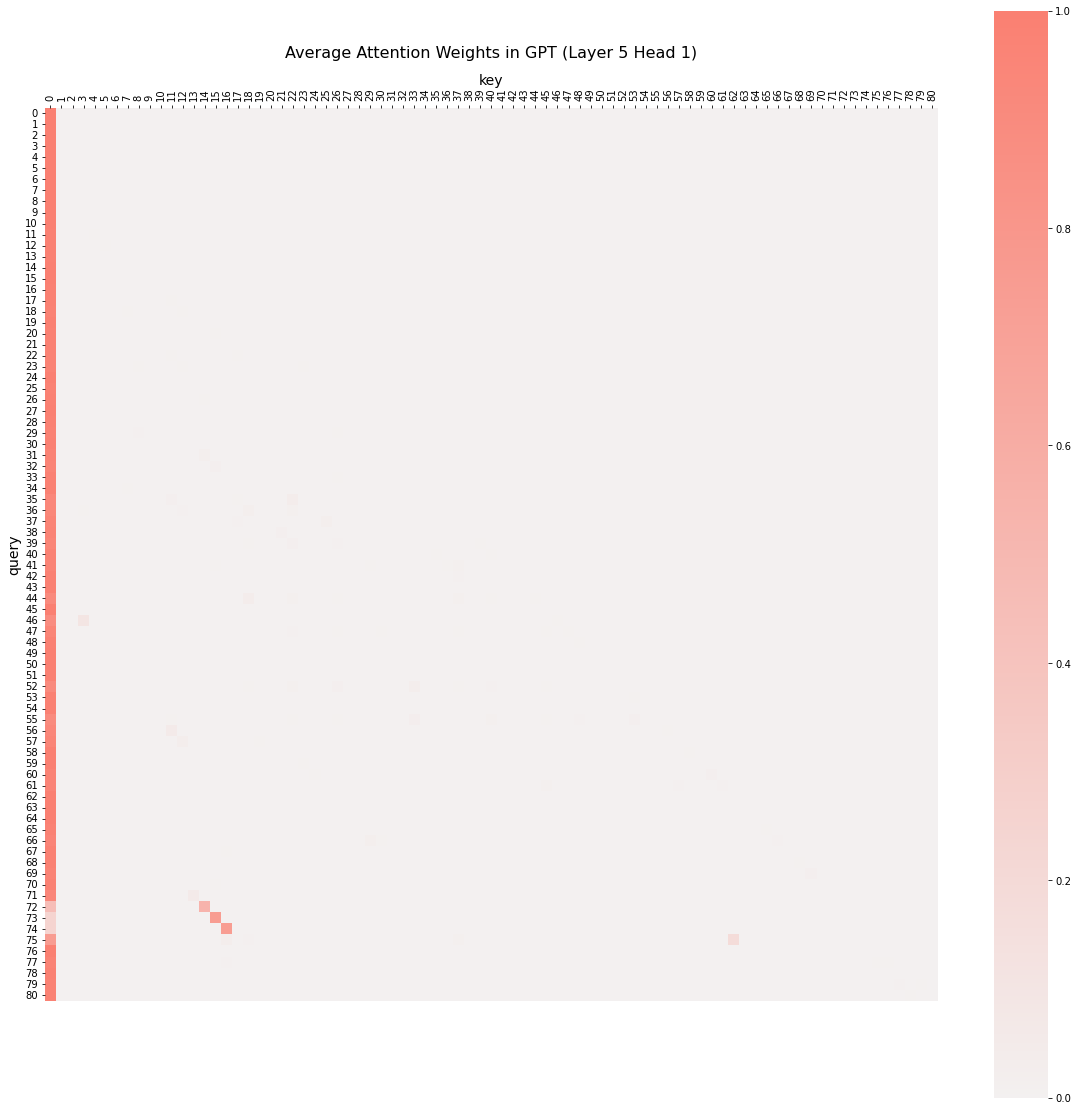

In [70]:
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(20, 20)
sns.heatmap(test, square=True, cmap=sns.color_palette("light:salmon", as_cmap=True))
axs.xaxis.tick_top()
axs.set_xlabel('key', fontsize=14)
axs.xaxis.set_label_position('top') 
plt.xticks(rotation = 90)
axs.set_ylabel('query', fontsize=14)
axs.set_title('Average Attention Weights in GPT (Layer 5 Head 1)', fontsize=16, y=1.05)

## Test Jesse Vig Plots

In [35]:
from bertviz import head_view
import torch

In [71]:
# format info for jesse vig plots
test12 = [[] for j in range(12)]
for i in range(len(test12)):
    empty = [test for i in range(12)]
    test12[i].append(empty)
    np_array = np.asarray(test12[i])
    test12[i] = torch.tensor(np_array)
    
print(len(test12))
print(len(test12[0]))
print(test12[0].shape)
print(len(test12[0][0]))

12
1
torch.Size([1, 12, 81, 81])
12


In [72]:
# generate html
html = head_view(test12, [str(i) for i in range(len(test))], layer=0, heads=[0], include_layers=[0], html_action='return')

with open('att.html', "w") as file: # save html to file
    file.write(html.data)